In [ ]:
import sys
#sys.path.append("../PFS_imaging/src")
sys.path.append("../src")
sys.path.append("../plot_tools")

from bias import *
from Loader import *
from Regression import *

from plot_util import *
from statistic import *

from astropy.table import Table, vstack
from pfstarget import cuts as Cuts
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import pandas as pd

import os

Calculate imaging attributes for healpixels within given tract

In [ ]:
#The name of the dust maps to be used
dustmaps = ['desi', 'desi-csfd', 'csfd']

#load the tract number to calculate imaging attributes
tractname = '../PFS/pfstarget/bin/hsc/sql/TractInfoS23.csv'
tracts = np.array(ascii.read(tractname)['tract'])

#calculates the {g,r,i,z,y}-seeing, {g,r,i,z,y}-depth, stellar density, effective area and E(B-V) magnitude for all dustmaps per healpixel
autumn, spring = imaging_bias(tractlist=tracts, dustmaps=dustmaps, savename='_test')

patch column missing in tract 9691 property
All observation area of tract 9933 is inside the bright stellar mask
All observation area of tract 10175 is inside the bright stellar mask
All observation area of tract 10417 is inside the bright stellar mask
No stars in tract 10906
patch column missing in tract 10912 property
No stars in tract 10916
patch column missing in tract 10917 property
No stars in tract 10455
No stars in tract 10465
No stars in tract 10913
No stars in tract 10456
No stars in tract 10914
patch column missing in tract 10899 property
No stars in tract 10457
No stars in tract 10915
No stars in tract 10905
All observation area of tract 9069 is inside the bright stellar mask
All observation area of tract 9797 is inside the bright stellar mask
All observation area of tract 10039 is inside the bright stellar mask


In [2]:
filename = '../property/spring_property_test.fits'
spring = Table.read(filename)

filename = '../property/autumn_property_test.fits'
autumn = Table.read(filename)

Get target list

In [3]:
import os
import numpy as np
import pandas as pd
from astropy.io import ascii
from astropy.table import Table
from concurrent.futures import ProcessPoolExecutor, as_completed

BASE1 = '/lustre/work/jingjing.shi/pfs_co_fa/data_proc/s23b_wide/tracts' #directory with full galaxy catalog
BASE2 = '/lustre/work/jingjing.shi/pfs_co_fa/data_raw/s23b-bsmask/tracts' #directory with the mask information

# reading in tractlists
tractname = '../PFS/pfstarget/bin/hsc/sql/TractInfoS23.csv'
tracts = np.array(ascii.read(tractname)['tract'])

def process_tract(tract):

    try:
        file1 = f'{BASE1}/s23b_gal_{tract}.fits'
        file2 = f'{BASE2}/{tract}.fits'
        if not (os.path.exists(file1) and os.path.exists(file2)):
            return None

        table1 = Table.read(file1, format='fits', memmap=True)
        table2 = Table.read(file2, format='fits', memmap=True)

        df1 = table1.to_pandas()
        df2 = table2.to_pandas()

        drop_cols = [c for c in ['ra', 'dec', 'tract', 'patch'] if c in df2.columns]
        if drop_cols:
            df2 = df2.drop(columns=drop_cols)

        # merge using object ID
        df = pd.merge(df1, df2, on='object_id', how='inner')

        # rename (name missmatch between saved data and what is required for the target selection)
        renames = {
            "i_cmodel_mag_meas": 'i_meas_cmodel_mag',
            "i_psf_mag_meas": 'i_meas_psf_mag',
            "i_cmodel_flag_meas": 'i_meas_cmodel_flag',
            "i_psf_flag_meas": 'i_meas_psf_flag',
        }
        existing = {k: v for k, v in renames.items() if k in df.columns}
        if existing:
            df = df.rename(columns=existing)

        if 'i_apertureflux_10_flux' in df.columns:
            flux = df['i_apertureflux_10_flux'].to_numpy()
            mag = np.full_like(flux, np.nan, dtype=float)
            pos = flux > 0
            # 1 nJy = 1e-9 Jy, AB: m = -2.5 log10(f_nu[Jy]) + 8.90
            # convert nJy to mag
            mag[pos] = -2.5 * (np.log10(flux[pos] / 3631.0) - 9.0)
            df['i_apertureflux_10_mag'] = mag

        from pfstarget import cuts as Cuts

        HSC = Cuts._prepare_hsc(df, dust_extinction='desi', release='s23b', zeropoint=False) ###Caution! different from the original code on github
        is_pfs_cosmo = Cuts.isCosmology(HSC)
        return HSC[is_pfs_cosmo]

    except Exception as e:
        print(f"[WARN] tract {tract} failed: {e}")
        return None

def run_parallel(tracts, max_workers=None):
    if max_workers is None:
        max_workers = min(15, os.cpu_count() or 4)

    results = []
    with ProcessPoolExecutor(max_workers=max_workers) as ex:
        futs = {ex.submit(process_tract, int(t)): t for t in tracts}
        for fut in as_completed(futs):
            res = fut.result()
            if res is not None:
                results.append(res)

    if len(results) == 0:
        return np.array([], dtype=float)  # 空
    return np.hstack(results)

targets = run_parallel(tracts)
print("done. targets shape:", np.shape(targets))

done. targets shape: (5326642,)


Calculate target density for each healpixel

In [ ]:
#
# targets: pandas dataframe including ra[deg] and dec[deg] of target galaxies
# autumn(spring): pandas dataframe including healpixel index 'healpix' and effective area[deg^2] 'area'
spring_pd = spring.to_pandas()
autumn_pd = autumn.to_pandas()
autumn_target1 = get_target_density(targets, autumn_pd)
spring_target1 = get_target_density(targets, spring_pd)

Visualize target density and imaging attributes

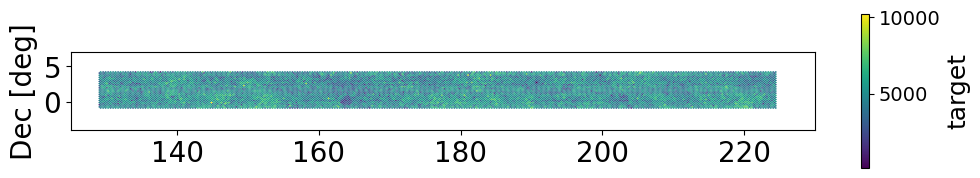

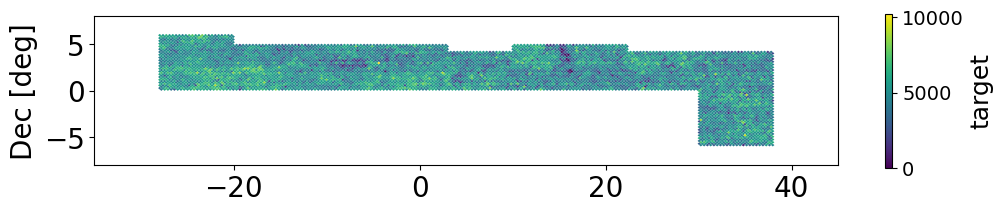

In [9]:
masked_autumn, masked_spring = mask_edge(autumn_target1, spring_target1) #removing the edges (this can be skipped)

target = 'target' # the column name you want to plot
field = 'spring' # the name of the field either spering or autumn
plot_map(masked_spring, target, field, vmin=None, vmax=None, cmap='viridis')

target = 'target'
field = 'autumn'
plot_map(masked_autumn, target, field, vmin=None, vmax=None, cmap='viridis')

Calculate density fluctuation as a function of imaging attributes

/home/YukaYamada/repository/PFS/../PFS/PFS_imaging/plot_tools/statistic.py:375: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(f'{key}_bin').apply(weighted_mean_rel).reset_index()
/home/YukaYamada/repository/PFS/../PFS/PFS_imaging/plot_tools/statistic.py:383: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _summary = jack_df.groupby(f'{key}_bin').apply(lambda x: weighted_mean_rel(x)[['mean']]).reset_index()
/home/YukaYamada/repository/PFS/../PFS/PFS_imaging/plot_tools/statistic.py:383: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version 

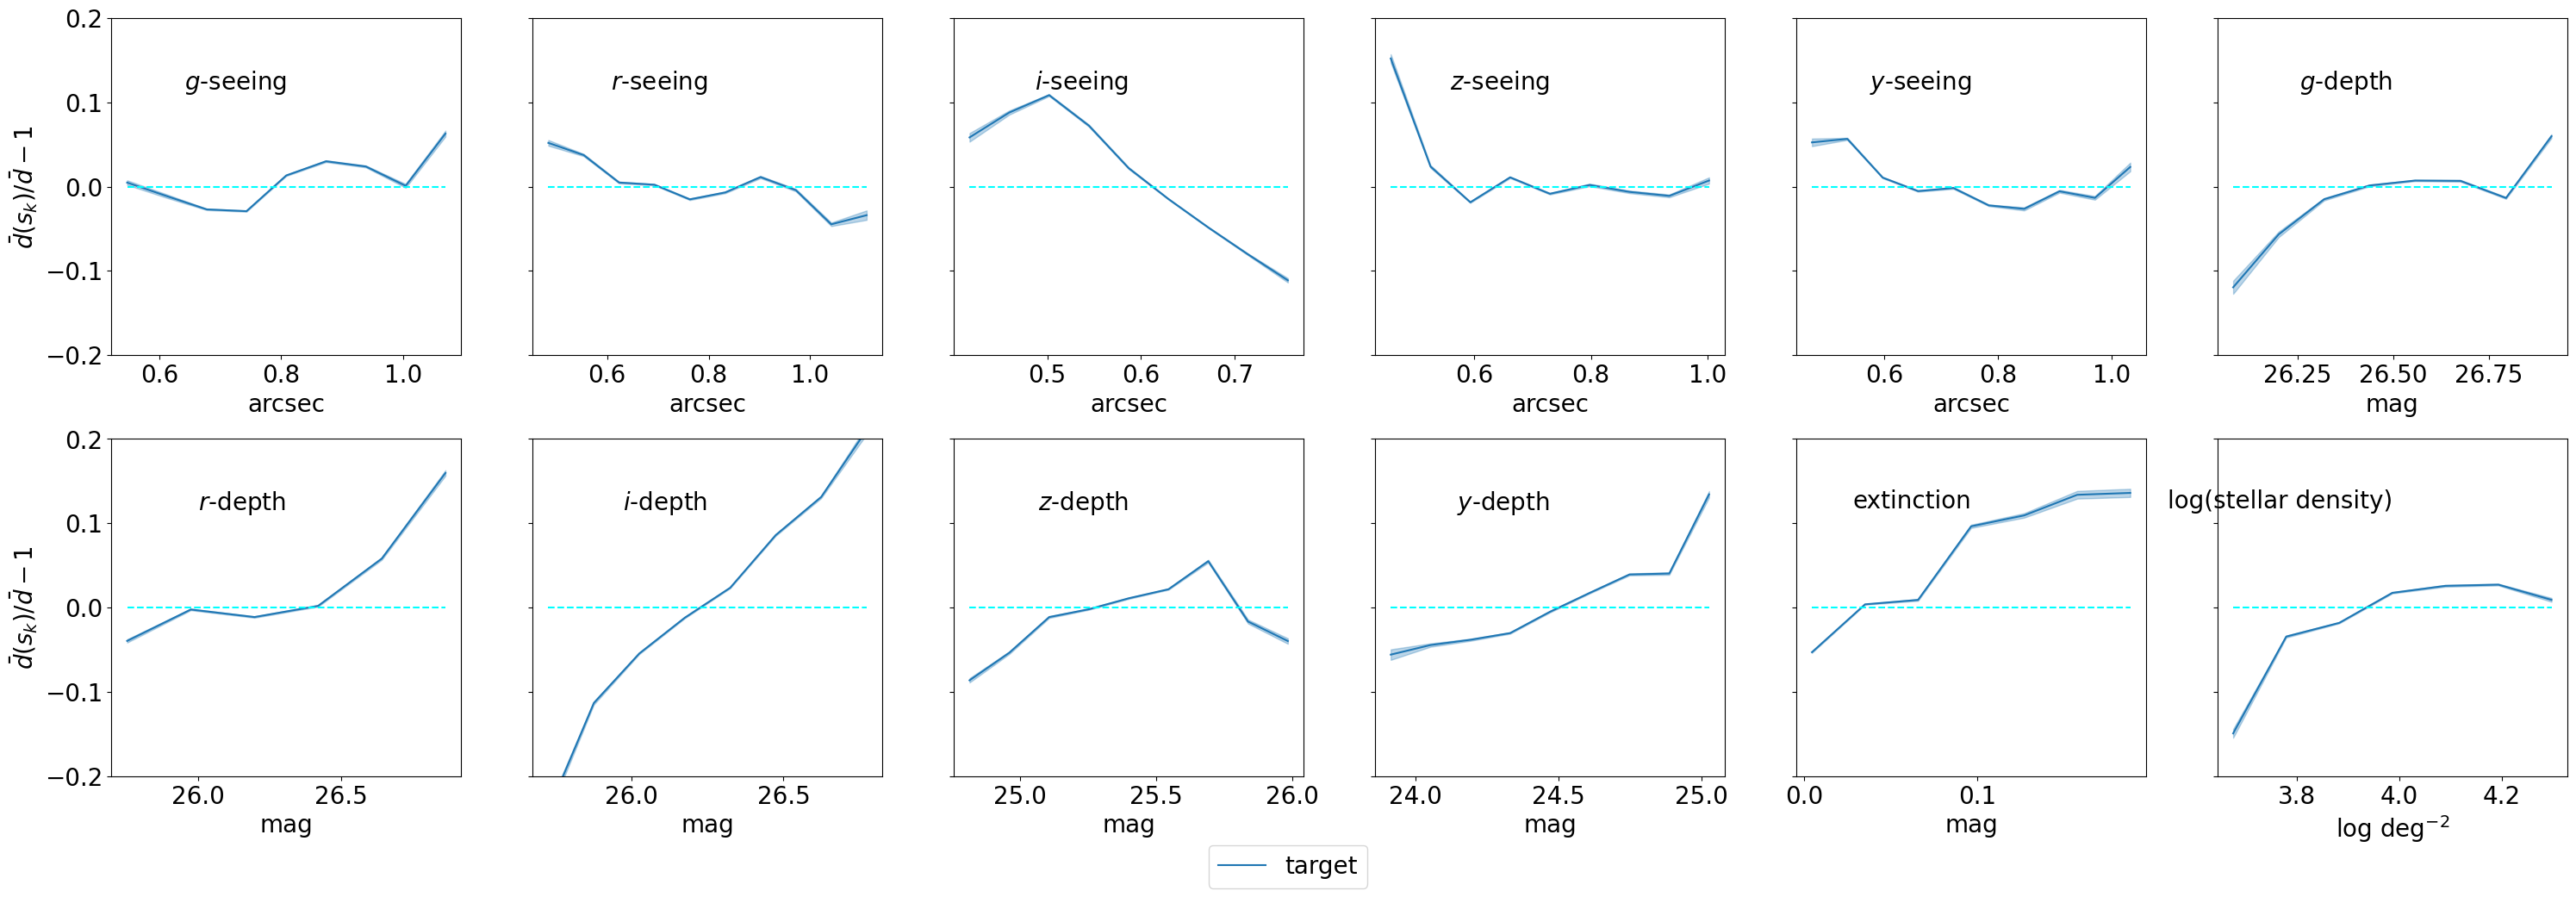

In [4]:
target_all = {'target':targets
           #'target1':targets1
           }

#field can calculate only for spring or autumn field
Plot_Dens(autumn, spring, target_all, field='all')

Calculate angular correlation function

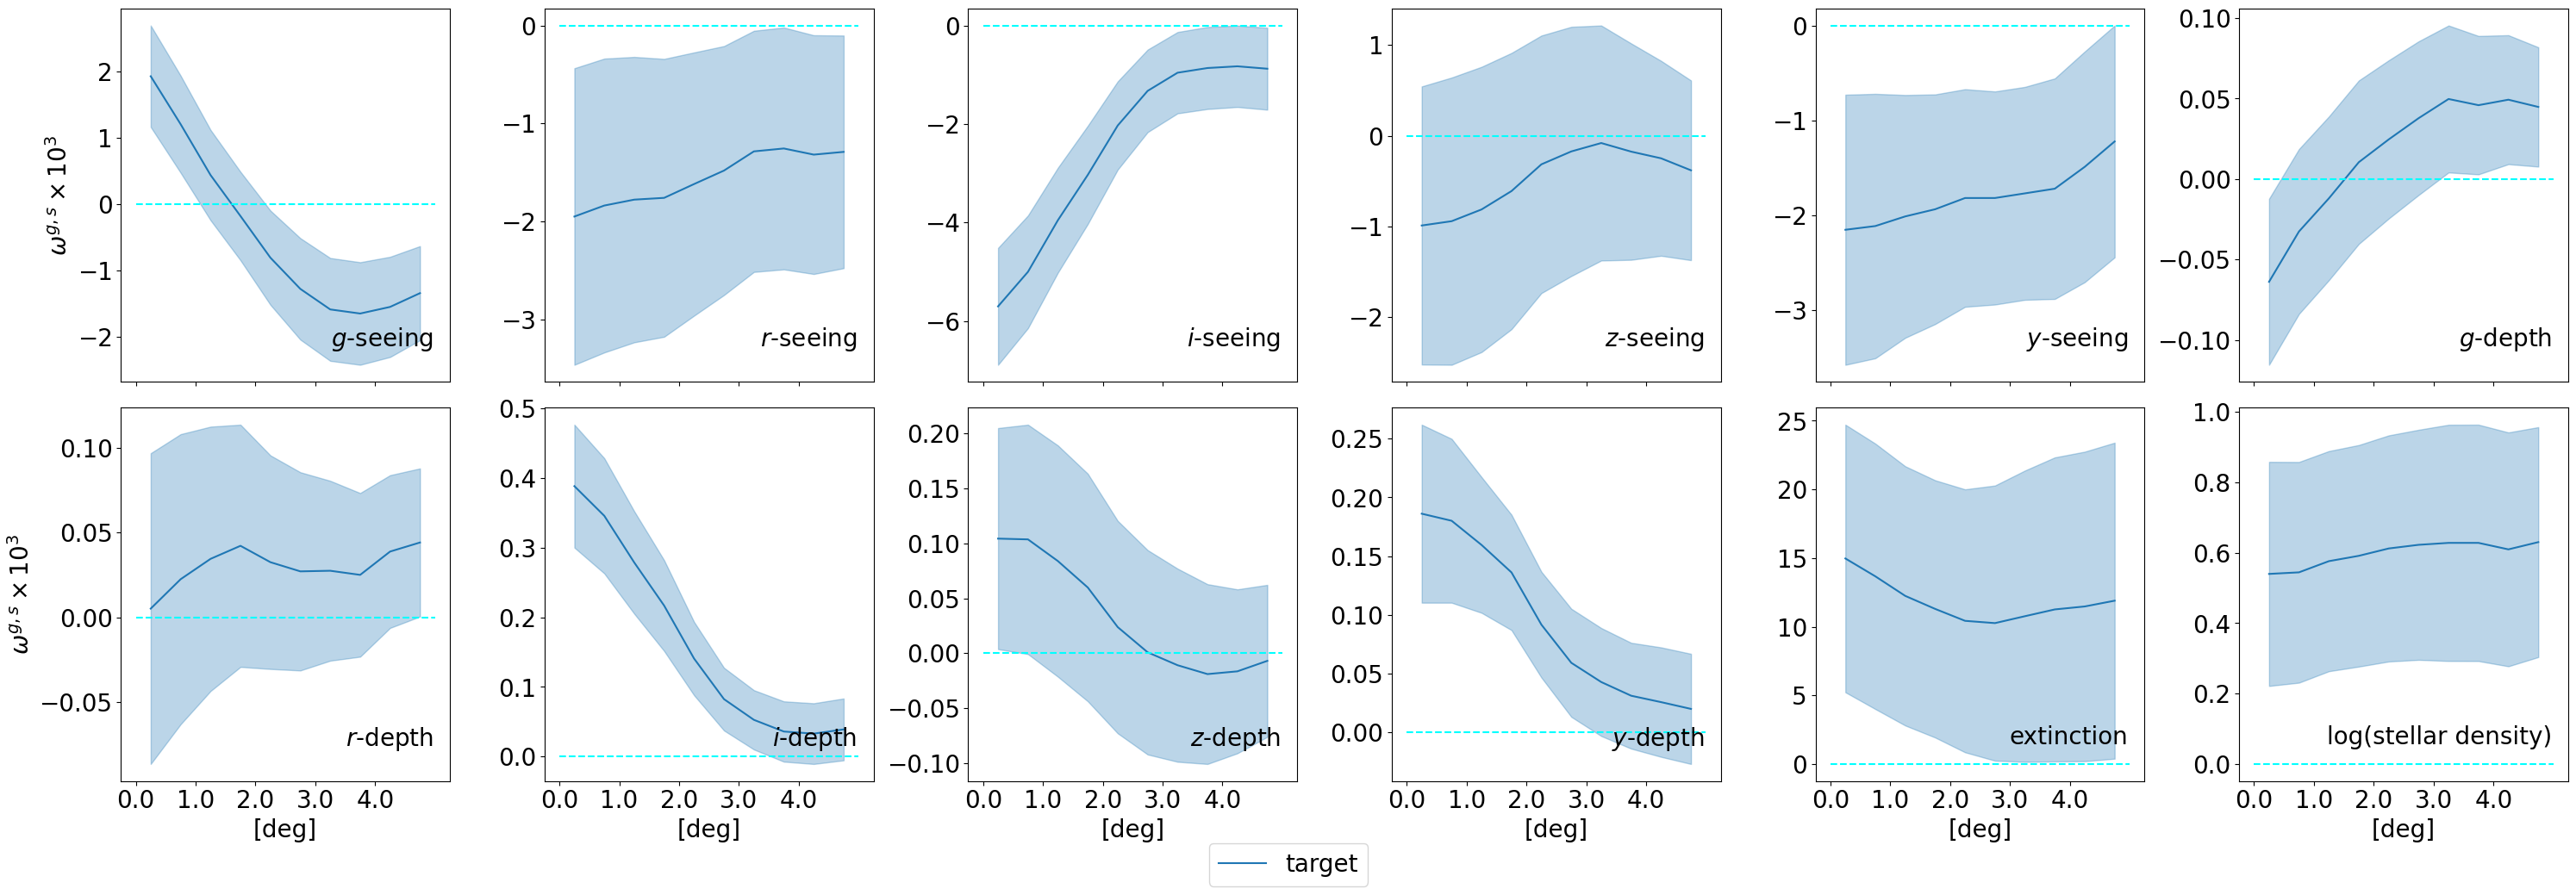

In [4]:
target_all = {'target':targets
           #'target1':targets1
           }

Plot_Ang(autumn, spring, target_all, field='all')

Calculate power spectrum

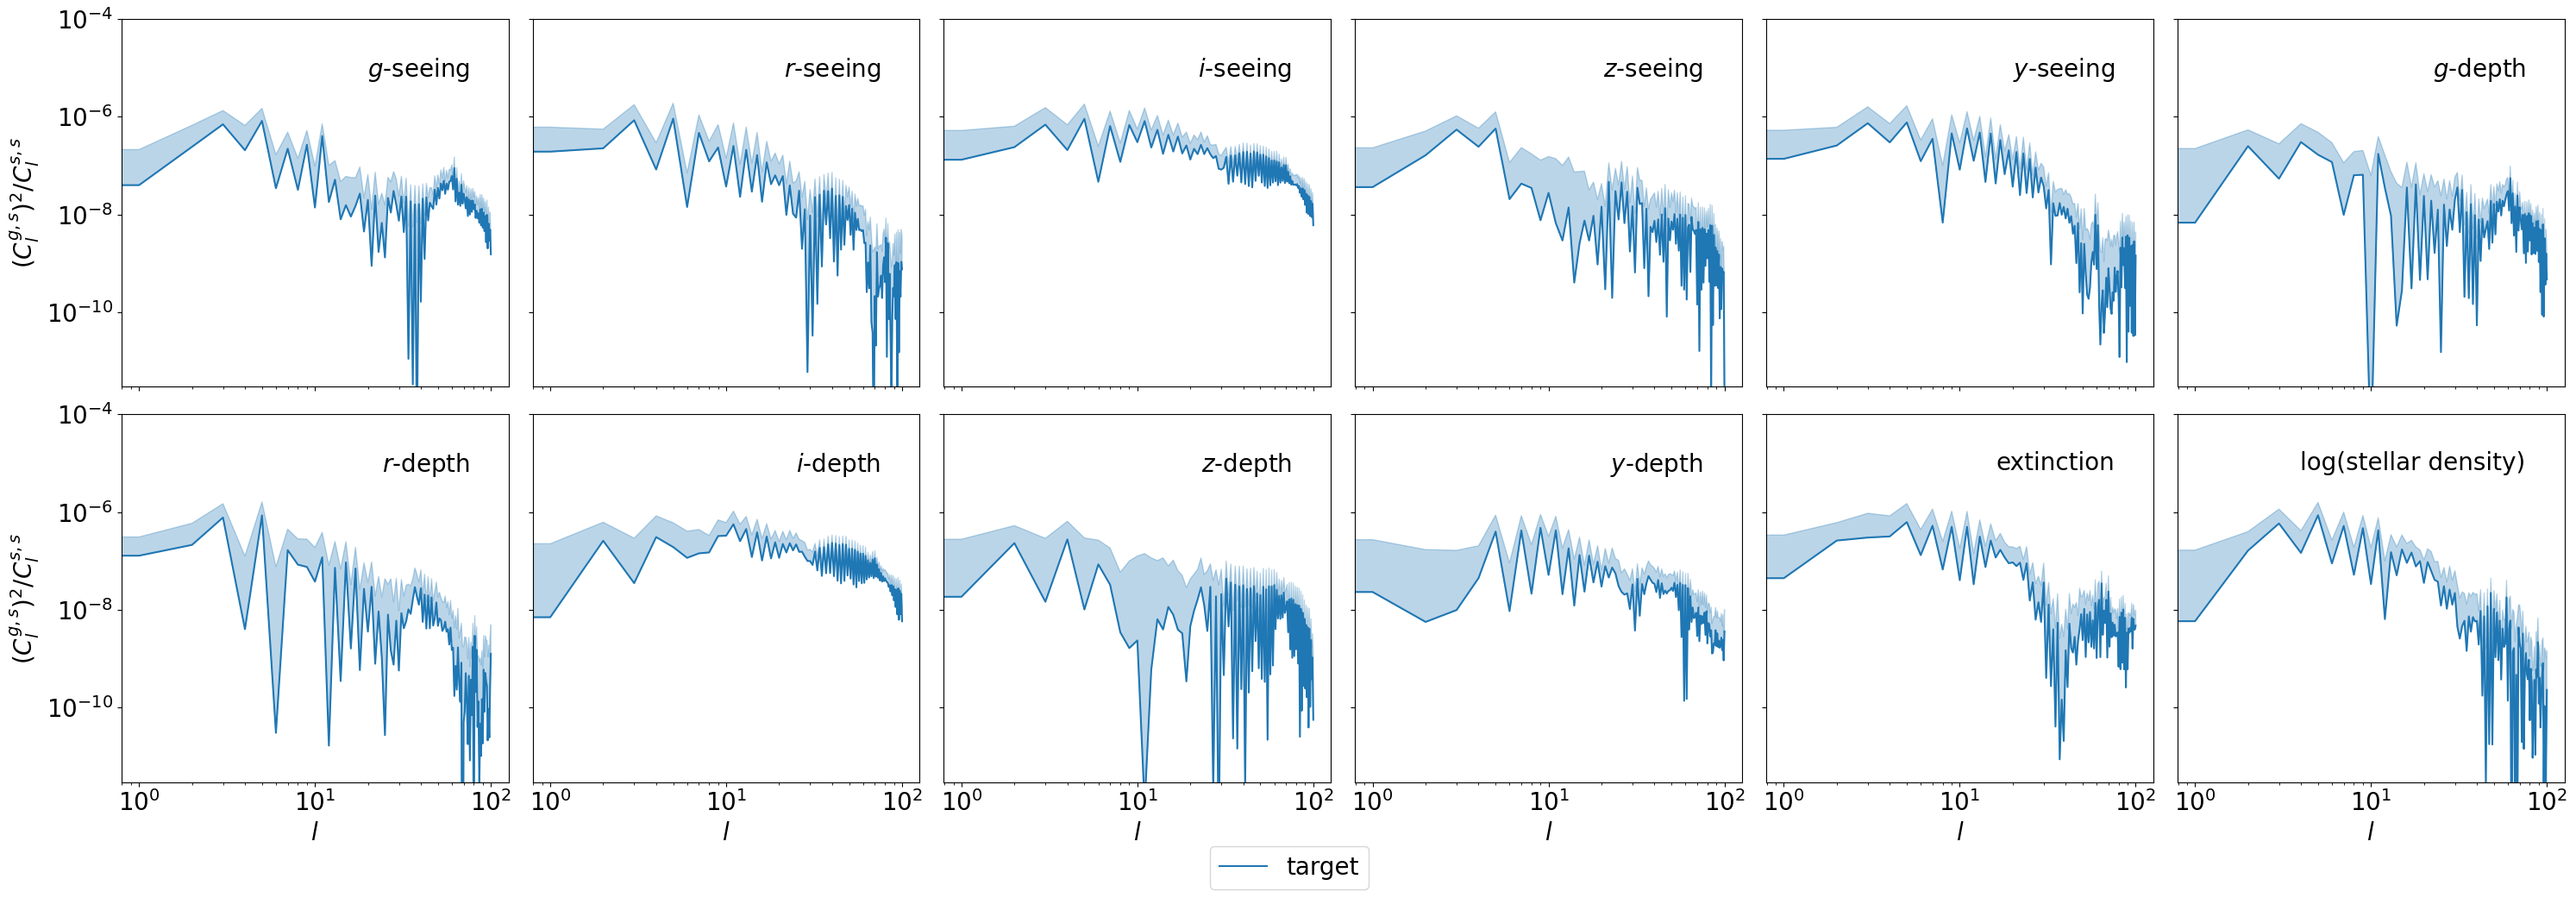

In [ ]:
target_all = {'target':targets
           #'target1':targets1
           }

Plot_PS(autumn, spring, target_all, field='all')